In [90]:
import numpy as np
import matplotlib

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
from scipy.misc import derivative
from scipy.integrate import solve_bvp
from functools import partial
from scipy import special as sp
from scipy import stats
import plasmapy.mathematics
import scipy.optimize as op
from functools import partial
from scipy import fftpack
from scipy import integrate
from scipy import signal
%config InlineBackend.figure_format = 'svg'
from matplotlib.animation import FFMpegWriter
from scipy.stats import pearsonr
from matplotlib.animation import FFMpegFileWriter
#%matplotlib notebook

In [473]:
tem = 1
L = 20
vmax = 20  # 10 * np.sqrt(tem)
nx = 101
nv = 1001
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
V, X = np.meshgrid(v, x)
dt = 0.01
max_steps  = 10000
data_steps = 10
data_num = int(max_steps/data_steps)
uai = 0.1
uae = 0.1
kappa = 5.0

path = './data/'

m=1
n=1
q=1
v_th = np.sqrt(2*tem)
l_D = np.sqrt( tem) # $\lambda_D^2$
w_pe = 1
print("data_num = ",data_num)

data_num =  1000


In [474]:
k = 2*np.pi/L
def eq4PDRM(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta = wc / k /v_th
    r = 1 + 1 / k**2 / l_D**2 * ( 1 + zeta*plasmapy.mathematics.plasma_dispersion_func(zeta) )
    return [r.real,r.imag]
#kvec = np.arange(.1,1.2,0.1)
print("k = ",k)
s=op.root(lambda w:eq4PDRM(w,k),[1,0.1])
v_p = s.x[0]/k
print("w_r = ",s.x[0])
print("w_i = ",s.x[1])
print("v_p = ",v_p)
print("rt = ", abs(s.x[1]/np.sqrt(0.004)))
print("1/r = ", abs(1/s.x[1]))
print('ltime',2*np.pi/k/dv)
print('rtime = ', max_steps*dt)

k =  0.3141592653589793
w_r =  1.176665582128872
w_i =  -0.017638244307415347
v_p =  3.745442875238251
rt =  0.27888512968965823
1/r =  56.69498520210353
ltime 500.0
rtime =  100.0


## 理论预测

In [475]:
def fm(v, t):
    r = np.sqrt(1./(2.*np.pi*t))*np.exp(-v**2/(2*t))
    return r
def fk(v, t, kappa):
    if(kappa == 0):
        r = fm(v, t)
    else:
        r = np.sqrt(m/(2.*np.pi*t*kappa)) * sp.gamma(kappa+1.5) / \
            sp.gamma(kappa+1) * (1 + m*v**2 / kappa / 2 / t) ** (-kappa-1.5)
    return r
def ue(x):
    r = 1.+uae*np.cos(2.*np.pi*x/L)
    return r
def ui(x):
    r = 1.+uai*np.cos(2.*np.pi*x/L)
    return r
def fkt(v, x, kappa):
    t = tem*ue(x)
    if(kappa == 0):
        r = fm(v, t)
    else:
        r = np.sqrt(m/(2.*np.pi*t*kappa)) * sp.gamma(kappa+1.5) / \
            sp.gamma(kappa+1) * (1 + m*v**2 / kappa / 2 / t) ** (-kappa-1.5)
    return r
#theoretical energy
def nphi(x):
    phi = -( n*q*(uae-uai) )/ (k**2)*np.cos(k*x)/L
    return (ui(x)-ue(x) )*q*phi
ek_theo = 0.5*tem
ep_theo = 0.5*integrate.quad(nphi,0,L)[0]
einit_theo=ek_theo+ep_theo

print("Ek = ",ek_theo)
print("Ep = ",ep_theo)
print("Etot = ",einit_theo)
def entropy(x,v):
    ufv = fk(v, tem,kappa)*ue(x)/L
    if (ufv==0.0):
        r = 0.0
    else:
        r = -ufv * np.log(ufv)
    return r
options = {'limit':50000}
entropyt_int_res = integrate.nquad(entropy,[[0,L],[-np.inf,np.inf]], opts=[options,options])
entropyt=entropyt_int_res[0]
print(entropyt)
def ug(x):
    r = (1. + uai * np.cos(k*x)) #/ (2*1.*a)
    return r

def ug_dev(x):
    r = -uai*k*np.sin(k*x)#/ 2. / a
    return r

def eq4U(x,yy,p):
    kappa,t=p
    dy, y = yy
    k_factor = (kappa+2) / (kappa+1)
    dy2y = (dy**2) / y
    ddy = k_factor * dy2y + (kappa+1) / (kappa) * (y**k_factor) * ( y-ui(x) ) / t * n * (q**2)
    return np.vstack((ddy, dy))

def bc4U(ya, yb):
    return np.array([ya[0]-yb[0],ya[1]-yb[1]])

xi = np.linspace(0, L, num=5000, dtype='complex',endpoint=False)
yguess = np.array([ug_dev(xi), ui(xi)])

def eq4para(x,energy,entropy):
    kp,tp = x
    sol4ode = solve_bvp(partial(eq4U, p=x), bc4U, xi,
                        yguess, tol=1e-13, max_nodes=50000)

    def ff(x):
        return sol4ode.sol(x)[1]
    def ff_r(x):
        return ff(x).real
    def ff_i(x):
        return ff(x).imag

    def ff_inti(x):
        r = ff(x)**(kp/(kp+1))
        return r
    def ff_inti_r(x):
        return ff_inti(x).real
    def ff_inti_i(x):
        return ff_inti(x).imag
        
    def ff_intii(x):
        r = ui(x) * (ff(x) ** (-1.0/(kp+1)))
        return r
    def ff_intii_r(x):
        return ff_intii(x).real
    def ff_intii_i(x):
        return ff_intii(x).imag
    
    def ff_intiii(x):
        r = ff(x)**(-1./(kp+1))
        return r
    def ff_intiii_r(x):
        return ff_intiii(x).real
    def ff_intiii_i(x):
        return ff_intiii(x).imag
    
    def entropy_pred(x, v):
        U_x = ff(x)
        
        if(kp==0):
            t_x = tp
            tempf = U_x * fm(v, t_x)+0j
        else:
            t_x = tp * U_x ** (-1./(kp+1))
            tempf = U_x * fk(v, t_x, kp)/L+0j
        if (tempf == 0.0+0.0j):
            r = 0.0
        else:
            r = -tempf * np.log(tempf)
        r = -tempf * np.log(tempf)
        return r
    def entropy_pred_r(x,v):
        return entropy_pred(x,v).real
    def entropy_pred_i(x,v):
        return entropy_pred(x,v).imag
    entropy_pred_int_r = integrate.dblquad(
        entropy_pred_r, -np.inf, np.inf,  0,  L, epsrel=1e-10)
    entropy_pred_int_i = integrate.dblquad(
        entropy_pred_i, -np.inf, np.inf,  0,  L, epsrel=1e-10)
    entropyp = entropy_pred_int_r[0] + 1j * entropy_pred_int_i[0]

    int_ff_r = integrate.quad(ff_r, 0, L, epsrel=1e-10)[0]-1.0
    int_ff_i = integrate.quad(ff_i, 0, L, epsrel=1e-10)[0]-1.0
    int_ff = int_ff_r + 1j * int_ff_i
    
    int_i_r = integrate.quad(ff_inti_r, 0, L, epsrel=1e-10)[0]
    int_i_i = integrate.quad(ff_inti_i, 0, L, epsrel=1e-10)[0]
    int_i = int_i_r + 1j * int_i_i

    int_ii_r = integrate.quad(ff_intii_r, 0, L, epsrel=1e-10)[0]
    int_ii_i = integrate.quad(ff_intii_i, 0, L, epsrel=1e-10)[0]
    int_ii = int_ii_r + 1j * int_ii_i

    int_iii_r = integrate.quad(ff_intiii_r, 0, L, epsrel=1e-10)[0]
    int_iii_i = integrate.quad(ff_intiii_i, 0, L, epsrel=1e-10)[0] 
    int_iii = (int_iii_r + 1j * int_iii_i) * int_ff

    eq1 = ((energy*2)*L - tp * (1+kp) * int_i + tp * kp * int_ii)/(energy*2)/L
    eq2 = (entropyp-entropy)/entropy

    return eq1.real,eq2.real

Ek =  0.5
Ep =  0.0
Etot =  0.5
4.405975113227708


In [476]:
para_guess = [5.0,1]# initial guess of parameters
sol_para = op.root(partial(eq4para,energy=einit_theo,entropy=entropyt), para_guess, method='hybr')
para = sol_para.x

print(para)
print(sol_para.fun,sol_para.success)

[4.91772332 1.00001519]
[ 7.10542736e-16 -2.01584983e-16] True


In [477]:
yguess = np.array([ug_dev(x), ui(x)])
sol = solve_bvp(partial(eq4U,p=para), bc4U, x, yguess,tol=1e-13,max_nodes=50000)
def ff(x):
    return sol.sol(x)[1].real
def t_theo(x):
    return para[1]*(ff(x).real)**(-1.0/(para[0]+1))
    #return (ff(x).real)**(-0.5)

## 函数定义&数据读取

In [478]:
def fm(v, t):
    r = np.sqrt(1./(2.*np.pi*t))*np.exp(-v**2/(2*t))
    return r
def fk(v, t, kappa):
    if(kappa == 0):
        r = fm(v, t)
    else:
        r = np.sqrt(m/(2.*np.pi*t*kappa)) * sp.gamma(kappa+1.5) / \
            sp.gamma(kappa+1) * (1 + m*v**2 / kappa / 2 / t) ** (-kappa-1.5)
    return r
def ue(x):
    r = 1.+uae*np.cos(2.*np.pi*x/L)
    return r
def ui(x):
    r = 1.+uai*np.cos(2.*np.pi*x/L)
    return r

In [479]:
progesses = np.arange(0,data_num,1)

f = []
E = []

for progess in progesses:
    f_temp = np.loadtxt(os.path.join(path,"data"+str(progess)))
    f.append(f_temp)
    E_temp = np.loadtxt(os.path.join(path,"E"+str(progess)))
    E.append(E_temp)

## 定态展示

In [480]:
dataet = np.loadtxt(os.path.join(path, "tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path, "pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path, "kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

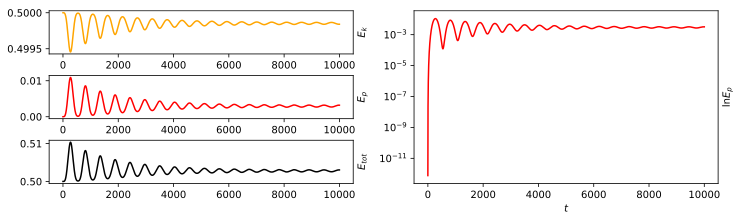

In [481]:
fig = plt.figure(figsize=(12, 3))

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 2), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.2)
plt.xlabel(r'$t$')
plt.show()

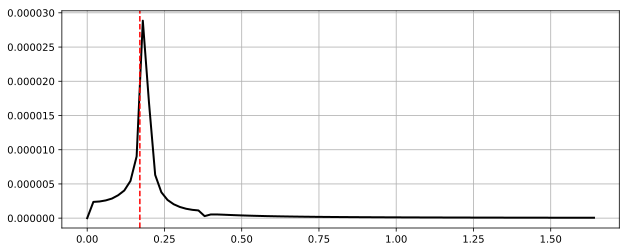

In [444]:
n = 5000
y_k = fftpack.fft(dataep[max_steps-1-n:max_steps-1])
x_k = fftpack.fftfreq(len(y_k),dt)
y_k_abs = np.abs(y_k)
y_k_phi = np.angle(y_k)
y_k_abs[0] = 0

plt.figure(figsize=(10,4))
    
ax2 = plt.subplot()
k_plot_scale=n//60
ax2.plot(x_k[0:k_plot_scale],2*y_k_abs[0:k_plot_scale]/n,color='black',lw=2)
ax2.axvline(s.x[0]/2/np.pi,color='red',ls='--')

ax2.grid()

### 分布函数fx fv

In [445]:
fx0 = np.sum(f[0],axis=1)*dv
fv0 = np.sum(f[0],axis=0)*dx/L
fx = np.sum(f[data_num-1],axis=1)*dv
fv = np.sum(f[data_num-1],axis=0)*dx/L
T0 = np.sum(v**2*f[0],axis=1)*dv/fx0
#T = np.sum(v**2*f[data_num-1],axis=1)*dv/fx
T_times = []
for i in range(100):
    f_temp = f[data_num-1-i]
    fx_temp = np.sum(f_temp,axis=1)*dv
    T_temp = np.sum(v**2*f_temp,axis=1)*dv/fx_temp
    T_times.append(T_temp)
T = np.mean(T_times,axis=0)

In [446]:
print(np.sum(np.sum(v**2*f[0],axis=1)*dv)*dx)

30.329999647985346


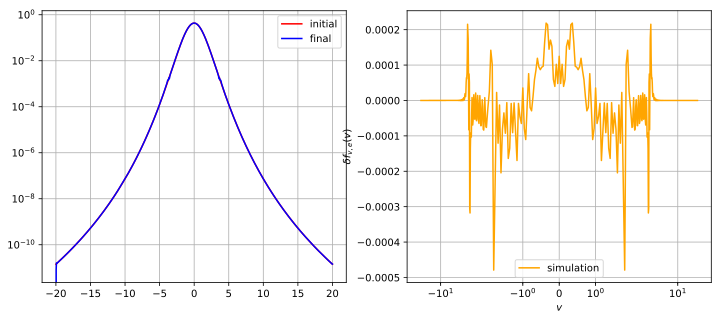

In [447]:
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.plot(v,fv0,color='r',label='initial')
ax1.plot(v,fv,color='blue',label='final')
ax1.set_yscale('log')

ax2.plot(v, fv-fv0, color='orange', label='simulation')
ax2.set_xlabel(r'$v$')
ax2.set_ylabel(r'$\delta f_{v,e}(v)$')
ax2.set_xscale('symlog')

ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

### 密度&温度分布

$$ \frac{n(x)}{n_0}=\left[ \frac{T(x)}{T_0} \right]^{-\kappa_0-1}$$
$$ \nabla \ln T = - \frac{1}{\kappa_0+1} \nabla \ln n$$

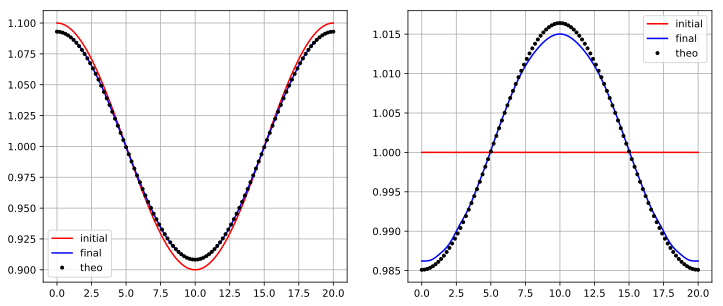

In [483]:
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.plot(x,fx0,color='r',label='initial')
ax1.plot(x,fx,color='blue',label='final')
ax1.plot(x,ff(x),'.',color='black',label='theo')

ax2.plot(x,T0,color='r',label='initial')
ax2.plot(x,T,color='blue',label='final')
ax2.plot(x,t_theo(x),'.',color='black',label='theo')
#ax2.plot(x,(fx)**(-1/2),'--',color='black',label='theo')
ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

LinregressResult(slope=-0.16638874328016512, intercept=-7.56583169856241e-07, rvalue=-0.9999909589365263, pvalue=1.3701981818364406e-236, stderr=7.11105513805953e-05)


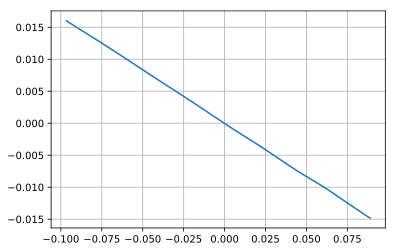

In [449]:
print(stats.linregress(np.log(fx),np.log(T)))
plt.plot(np.log(fx),np.log(T))
plt.grid()
plt.show()

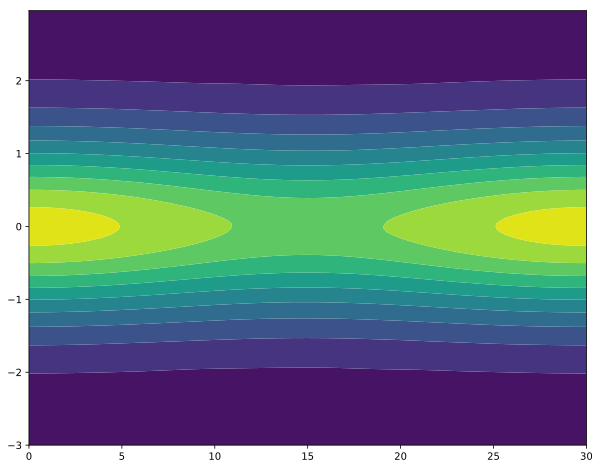

In [450]:
vstart = -3
vend = 3
nvs = int((vstart + vmax ) / dv)
nve = int((vend + vmax) /dv)
fig = plt.figure(figsize=(10,8))
ax = plt.subplot()
Z = f[data_num-1]
plt.contourf(X[:,nvs:nve],V[:,nvs:nve],Z[:,nvs:nve],levels=10)
plt.show()

## 动态过程

### 密度温度动态分析

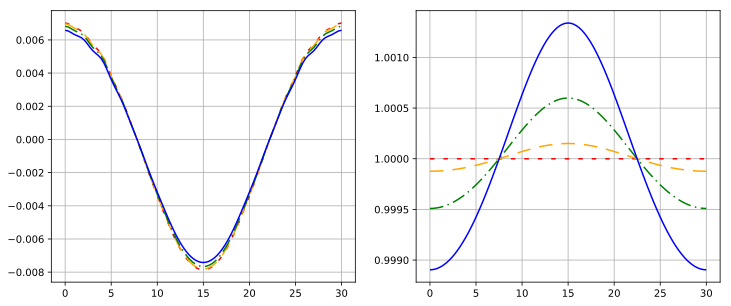

In [451]:
frames = [0,1,2,3]
dash_style = [
    [3,6],[9,6],[9,3,1,3],[10,0]
]
colors_style = ['red','orange','green','blue']

fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
for frame in frames:
    Z = f[frame*1]
    fz = np.sum(Z,axis=1)*dv
    T = np.sum(v**2*Z,axis=1)*dv/fz
    ax1.plot(x,fz-fx,c=colors_style[frame],dashes=dash_style[frame])
    ax2.plot(x,T,c=colors_style[frame],dashes=dash_style[frame])
ax1.grid()
ax2.grid()
plt.show()

### 局部温度随时间演化

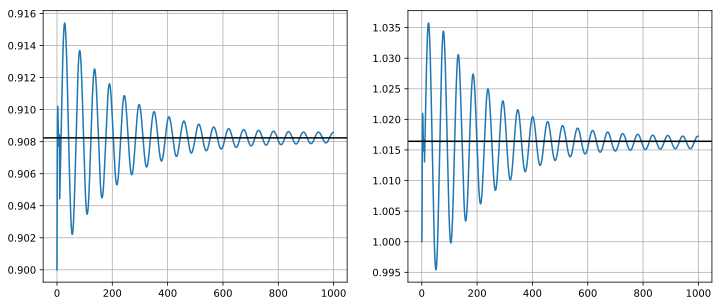

In [484]:
ntx0 = []
Ttx0 = []
for progess in progesses:
    Z = f[progess]
    fz = np.sum(Z,axis=1)*dv
    T = np.sum(v**2*Z,axis=1)*dv/fz
    ntx0.append(fz[nx//2])
    Ttx0.append(T[nx//2])


    
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.plot(progesses,ntx0)
ax1.axhline(ff(L/2),color='black')

ax2.plot(progesses,Ttx0)
ax2.axhline(t_theo(L/2),color='black')

ax1.grid()
ax2.grid()
plt.show()

In [470]:
idxs = 20
idxe = 25
idx, _ = signal.find_peaks(Ttx0, distance=5)
Tmax_idx = idx[idxs:idxe]
Tmax = np.array(Ttx0)[Tmax_idx]
idx, _ = signal.find_peaks(-np.array(Ttx0), distance=5)
Tmin_idx = idx[idxs:idxe]
Tmin = np.array(Ttx0)[Tmin_idx]

idx, _ = signal.find_peaks(ntx0, distance=5)
nmax_idx = idx[idxs:idxe]
nmax = np.array(ntx0)[nmax_idx]
idx, _ = signal.find_peaks(-np.array(ntx0), distance=5)
nmin_idx = idx[idxs:idxe]
nmin = np.array(ntx0)[nmin_idx]

n_aver = np.mean(ntx0[data_num-1-100:data_num-1])
T_aver = np.mean(Ttx0[data_num-1-100:data_num-1])

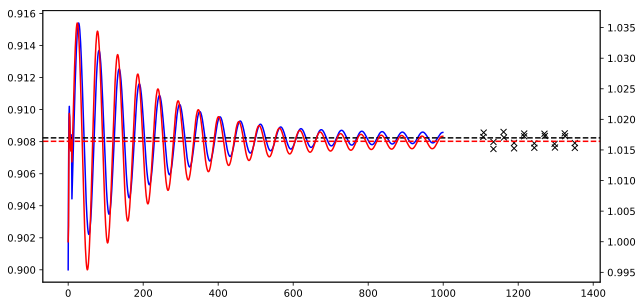

In [485]:
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.plot(progesses,ntx0,color='blue')
ax1.plot(nmax_idx,nmax,'x',color='black')
ax1.plot(nmin_idx,nmin,'x',color='black')
ax1.axhline(ff(L/2),ls='--',color='black')

ax2.plot(progesses,Ttx0,color='red')
ax2.plot(Tmax_idx,Tmax,'x',color='black')
ax2.plot(Tmin_idx,Tmin,'x',color='black')
ax2.axhline(t_theo(L/2),ls='--',color='red')
#ax1.axhline(n_aver,ls='--',color='black')
#ax2.axhline(T_aver,ls='--',color='red')

plt.show()

In [472]:
print(2*np.pi/((Tmax_idx[2]-Tmax_idx[1])*dt*data_steps))
print(2*np.pi/((nmax_idx[2]-nmax_idx[1])*dt*data_steps))
print("w_r = ",s.x[0])

1.1635528346628863
1.1423973285781066
w_r =  1.0707983708963584


In [469]:
print("dn/dT",(nmax-nmin).mean()/(Tmax-Tmin).mean())
print("(-k0-1)n/T",(-kappa-1)*(nmax+nmin).mean()/(Tmax+Tmin).mean())
print("(-k0-1)n/T",(-kappa-1)*n_aver/T_aver)

dn/dT 1.640115347014609
(-k0-1)n/T -5.36226578136754
(-k0-1)n/T -5.36285661177524


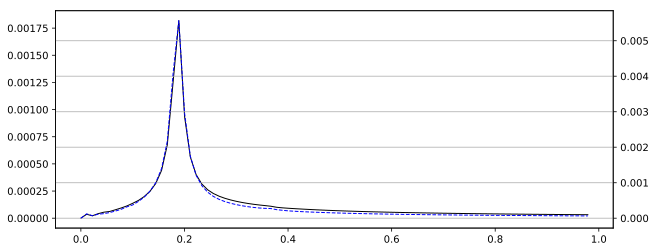

In [457]:
ns = 1
ne = 900
n = ne - ns
n_k = fftpack.fft(ntx0[ns:ne])
T_k = fftpack.fft(Ttx0[ns:ne])
x_k = fftpack.fftfreq(len(n_k),dt*data_steps)
n_k_abs = np.abs(n_k)
T_k_abs = np.abs(T_k)
n_k_abs[0] = 0
T_k_abs[0] = 0

k_plot_scale=n//10

plt.figure(figsize=(10,4))
ax1 = plt.subplot()
ax2 = ax1.twinx()

ax1.plot(x_k[0:k_plot_scale],2*n_k_abs[0:k_plot_scale]/n,color='black',lw=1)
ax2.plot(x_k[0:k_plot_scale],2*T_k_abs[0:k_plot_scale]/n,'--',color='blue',lw=1)
#ax2.axvline(s.x[0]/2/np.pi,color='red',ls='--')
#ax2.set_ylim(-0.002,0.004)
ax2.grid()

In [458]:
print("theo:",t_theo(L/2))
print("sim:",np.mean(Ttx0[-100:]))
print("aver-sim",T[nx//2])

theo: 1.017259557603605
sim: 1.0161440978255707
aver-sim 1.0150240581943457


### 热流粒子流

In [459]:
frame = 2
f_test = f[frame]
fx_test = np.sum(f_test,axis=1)*dv
G_test = np.sum(v*f_test,axis=1)*dv
uu = G_test/fx_test
def q_calc(i):
    #return np.sum((v)**3*f_test[i,:]/2)*dv
    return np.sum((v-uu[i])**3*f_test[i,:]/2)*dv
def p_calc(i):
    #return np.sum((v)**2*f_test[i,:]/2)*dv
    return np.sum((v-uu[i])**2*f_test[i,:])*dv
def t_calc(i):
    return np.sum((v-uu[i])**2*f_test[i,:])*dv/fx_test[i]
Q_test = []
p_test = []
T_test = []
for i in range(nx):
    Q_test.append(q_calc(i))
    p_test.append(p_calc(i))
    T_test.append(t_calc(i))
#Q_test = np.sum((v)**3*f_test/2,axis=1)*dv
#p_test = np.sum(v**2*f_test,axis=1)*dv
force_test = E[frame]*(-1)*fx_test/L - np.gradient(p_test)

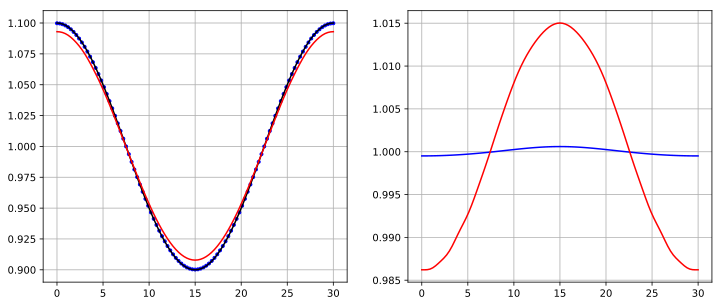

In [460]:
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
ax1.plot(x,fx_test,'.',color='blue',label='now')
ax1.plot(x,fx0,color='black',label='init')
ax1.plot(x,fx,color='red',label='final')
ax2.plot(x,T_test,color='blue')
ax2.plot(x,T,color='red',label='final')
ax1.grid()
ax2.grid()
plt.show()

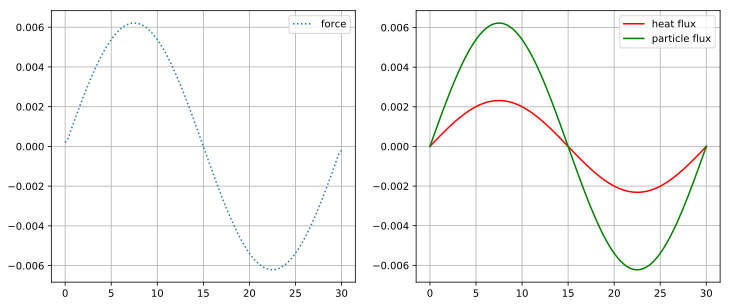

In [461]:
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
ax1.plot(x,force_test,':',label='force')
ax2.plot(x,Q_test,color='red',label='heat flux')
ax2.plot(x,G_test,color='green',label='particle flux')
ax1.grid()
ax2.grid()
ax1.legend()
ax2.legend()
plt.show()

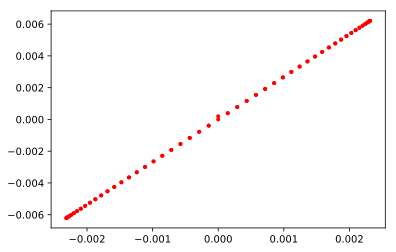

LinregressResult(slope=2.6828008671488193, intercept=1.9540396483227544e-06, rvalue=0.9999897540537317, pvalue=1.4881129802431506e-231, stderr=0.0012267887151233446)


In [462]:
plotend = int((nx-1))
plt.plot(Q_test[0:plotend],force_test[0:plotend],'.',color='red')
plt.show()
print(stats.linregress(Q_test[0:plotend],force_test[0:plotend]))

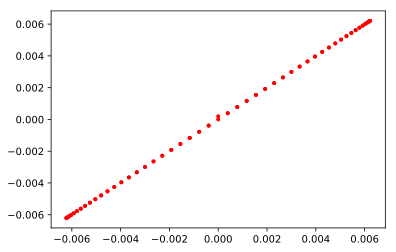

LinregressResult(slope=0.9975932993154755, intercept=1.960023550794181e-06, rvalue=0.9999899867798152, pvalue=4.827265617450685e-232, stderr=0.0004509678981180764)


In [463]:
plt.plot(G_test[0:plotend],force_test[0:plotend],'.',color='red')
plt.show()
print(stats.linregress(G_test[0:plotend],force_test[0:plotend]))

## 其他影响

### Debye Length & w_p

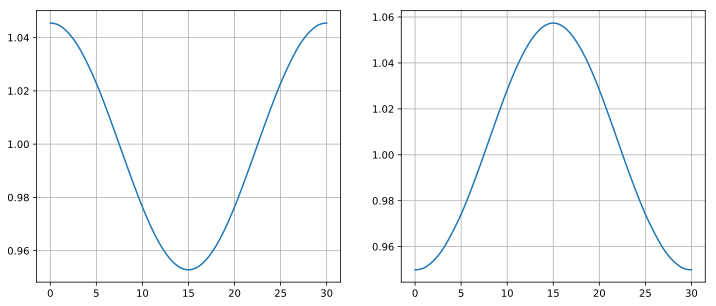

In [464]:
w_p = np.sqrt(fx)
lambda_D = np.sqrt(T/fx)
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
ax1.plot(x,w_p)
ax2.plot(x,lambda_D)
ax1.grid()
ax2.grid()
plt.show()